In [5]:
import numpy as np
import talib
import os
import pandas_datareader as pdr
import pandas as pd
from dotenv import load_dotenv

load_dotenv()
META = pdr.get_data_tiingo('META',api_key = os.getenv('api_key'))
META.tail()

/var/folders/lw/6vvkjf6919ndmlnqfvwpynlh0000gn/T/ipykernel_38823/134335718.py:9: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  META = pdr.get_data_tiingo('META',api_key = os.getenv('api_key'))


close      high     low     open    volume  \
symbol date                                                                     
META   2025-03-13 00:00:00+00:00  590.64  620.5000  586.51  620.245  16480324   
       2025-03-14 00:00:00+00:00  607.60  608.8600  594.78  602.805  12364505   
       2025-03-17 00:00:00+00:00  604.90  613.1000  598.00  607.460  15473909   
       2025-03-18 00:00:00+00:00  582.36  600.2500  574.66  600.050  20297708   
       2025-03-19 00:00:00+00:00  584.06  592.3223  574.77  584.280  20537498   

                                    adjClose     adjHigh     adjLow  \
symbol date                                                           
META   2025-03-13 00:00:00+00:00  590.130095  619.964317  586.00366   
       2025-03-14 00:00:00+00:00  607.600000  608.860000  594.78000   
       2025-03-17 00:00:00+00:00  604.900000  613.100000  598.00000   
       2025-03-18 00:00:00+00:00  582.360000  600.250000  574.66000   
       2025-03-19 00:00:00+00:00  584.060000  592.322300  574.77000   

                                     adjOpen  adjVolume  divCash  splitFactor  
symbol date                                                                    
META   2025-03-13 00:00:00+00:00  619.709537   16480324    0.000          1.0  
       2025-03-14 00:00:00+00:00  602.805000   12364505    0.525          1.0  
       2025-03-17 00:00:00+00:00  607.460000   15473909    0.000          1.0  
       2025-03-18 00:00:00+00:00  600.050000   20297708    0.000          1.0  
       2025-03-19 00:00:00+00:00  584.280000   20537498    0.000          1.0

In [9]:
META_adj=META.iloc[:,5:9] 
META_adj.columns = ['Close', 'High', 'Low', 'Open'] 
META_adj = META_adj.reset_index() #從多index變成單一index
META_adj.index = META_adj['date'] # 將index設為date
META_adj = META_adj.iloc[-300:,2:6] 
META_adj_300 = pd.DataFrame(META_adj)
META_adj_300

,Close,High,Low,Open
date,,,,
2024-01-08 00:00:00+00:00,356.992360,357.310872,350.413094,353.050772
2024-01-09 00:00:00+00:00,355.768079,358.963153,353.707703,354.742868
2024-01-10 00:00:00+00:00,368.747447,371.205963,357.410407,358.495339
2024-01-11 00:00:00+00:00,367.951167,371.046707,361.242506,370.399729
2024-01-12 00:00:00+00:00,372.748756,375.306806,367.821772,368.433912
...,...,...,...,...
2025-03-13 00:00:00+00:00,590.130095,619.964317,586.003660,619.709537
2025-03-14 00:00:00+00:00,607.600000,608.860000,594.780000,602.805000
2025-03-17 00:00:00+00:00,604.900000,613.100000,598.000000,607.460000


In [15]:
Close = META_adj_300.Close
Open = META_adj_300.Open

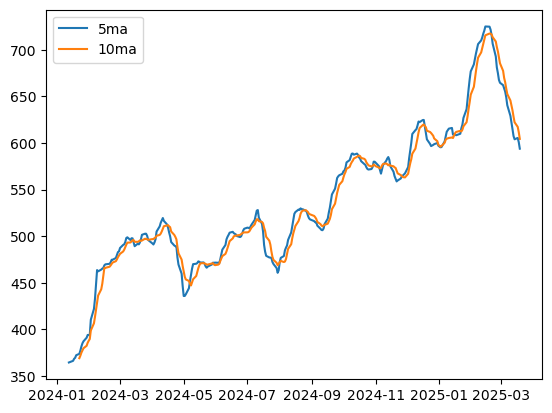

In [19]:
# 取５天及１０天的移動平均
SMA_5 = talib.SMA(Close, timeperiod=5)
SMA_10 = talib.SMA(Close, timeperiod=10)

import matplotlib.pyplot as plt

plt.plot(SMA_5)
plt.plot(SMA_10)
plt.legend(['5ma','10ma'])

In [33]:
# 撰寫策略：
# 當５日均線大於１０日均線，買入
# 當５日均線小於１０日均線，賣出

SMA_diff = SMA_5 - SMA_10
stock = 0
signal = []

for i in range(len(SMA_diff)):
    # 當５日均線大於１０日均線，買入
    if SMA_diff[i-1] < 0 and SMA_diff[i] > 0 and stock ==0:
        stock += 1
        signal.append(1)
    # 當５日均線小於１０日均線，賣出
    elif SMA_diff[i-1] > 0 and SMA_diff[i] < 0 and stock > 0:
        stock -= 1
        signal.append(-1)
    else:
        signal.append(0)

# 製作dataframe
import pandas as pd
ma_sig = pd.Series(index = SMA_diff.index, data = signal)
ma_sig

date
2024-01-08 00:00:00+00:00    0
2024-01-09 00:00:00+00:00    0
2024-01-10 00:00:00+00:00    0
2024-01-11 00:00:00+00:00    0
2024-01-12 00:00:00+00:00    0
                            ..
2025-03-13 00:00:00+00:00    0
2025-03-14 00:00:00+00:00    0
2025-03-17 00:00:00+00:00    0
2025-03-18 00:00:00+00:00    0
2025-03-19 00:00:00+00:00    0
Length: 300, dtype: int64

In [50]:
# 計算投報率
ret = []
transaction = []
stock = 0
stock_history = []
buy_price = 0
sell_price = 0

for i in range(len(ma_sig)-1):
    stock_history.append(stock)
    # 隔天開盤買入
    if ma_sig[i] == 1:
        buy_price = Open[ma_sig.index[i+1]]
        stock += 1
        transaction.append([ma_sig.index[i+1],buy_price,'BUY'])
    # 隔天開盤賣出
    elif ma_sig[i] == -1:
        sell_price = Open[ma_sig.index[i+1]]
        stock -= 1
        transaction.append([ma_sig.index[i+1],sell_price,'SELL'])
        ret.append((sell_price-buy_price)/buy_price)
        buy_price = 0
        sell_price = 0
    else:
        continue

total_ret = 1
for r in ret:
    total_ret *= 1 + r
# print(str(round((total_ret - 1)*100,2)) + '%')
print('總報酬率：' + str(round(100*(total_ret-1),2)) + '%')
transaction


總報酬率：29.87%


[[Timestamp('2024-03-22 00:00:00+0000', tz='UTC'), 505.1817453491, 'BUY'],
 [Timestamp('2024-04-01 00:00:00+0000', tz='UTC'), 485.4527541106, 'SELL'],
 [Timestamp('2024-04-08 00:00:00+0000', tz='UTC'), 527.3818425609, 'BUY'],
 [Timestamp('2024-04-17 00:00:00+0000', tz='UTC'), 501.2957319234, 'SELL'],
 [Timestamp('2024-05-08 00:00:00+0000', tz='UTC'), 461.8377494464, 'BUY'],
 [Timestamp('2024-05-22 00:00:00+0000', tz='UTC'), 466.1920773106, 'SELL'],
 [Timestamp('2024-05-30 00:00:00+0000', tz='UTC'), 469.9784493665, 'BUY'],
 [Timestamp('2024-06-24 00:00:00+0000', tz='UTC'), 497.903023915, 'SELL'],
 [Timestamp('2024-06-28 00:00:00+0000', tz='UTC'), 515.8063878559, 'BUY'],
 [Timestamp('2024-07-16 00:00:00+0000', tz='UTC'), 500.197048264, 'SELL'],
 [Timestamp('2024-08-05 00:00:00+0000', tz='UTC'), 450.1723564281, 'BUY'],
 [Timestamp('2024-08-27 00:00:00+0000', tz='UTC'), 517.6316333162, 'SELL'],
 [Timestamp('2024-09-16 00:00:00+0000', tz='UTC'), 523.6677154957, 'BUY'],
 [Timestamp('2024-10-